Import libraries

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

Load dataset and prepare df. Keeping only those columns, that are not directly computed out of new deaths, and have the highest correlation

In [16]:
file_path = "./data/WHO-COVID-19-global-data.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=[date_column])

In [17]:

date = df[date_column]
df = df.groupby(date_column).sum().reset_index()
df.set_index(date_column, inplace=True)
# df = df.select_dtypes(exclude=['object'])
correlation_with_target = (
    df.select_dtypes(exclude=["object"])
    .drop(columns=[target_column])
    .corrwith(df[target_column])
)
most_corr = correlation_with_target.sort_values(ascending=False).index.tolist()
most_corr = list(set(most_corr[:10] + most_corr[-10:]))
df = df[most_corr].merge(df[target_column], left_index=True, right_index=True)
most_corr

['Cumulative_cases', 'Cumulative_deaths', 'New_cases']

Plot the dataset

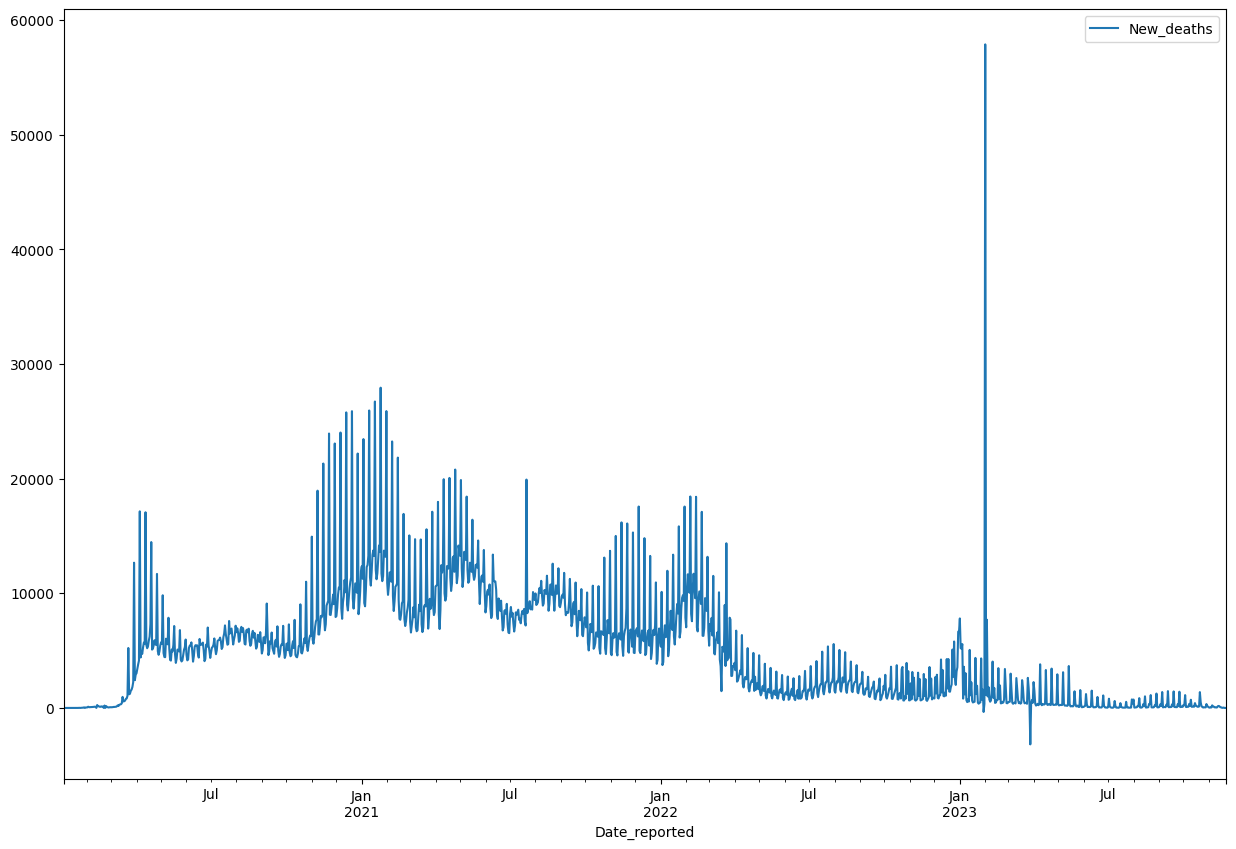

In [18]:
plot_cols = [target_column]
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True, figsize=(15, 10))

Display first values

In [19]:
df.head()

,Cumulative_cases,Cumulative_deaths,New_cases,New_deaths
Date_reported,,,,
2020-01-03,0,0,0,0
2020-01-04,3,0,3,0
2020-01-05,2,3,-1,3
2020-01-06,5,3,3,0
2020-01-07,5,3,0,0


In [20]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Cumulative_cases,1420.0,3.656805e+08,2.941915e+08,0.0,77590340.00,270009407.5,6.395637e+08,772166517.0
Cumulative_deaths,1420.0,4.384444e+06,2.535844e+06,0.0,1841189.75,5355267.5,6.644023e+06,6981263.0
New_cases,1420.0,5.437792e+05,8.657419e+05,-1.0,93110.50,350797.0,5.870945e+05,8401963.0
New_deaths,1420.0,4.916382e+03,4.869881e+03,-3179.0,746.00,4517.0,7.720250e+03,57889.0


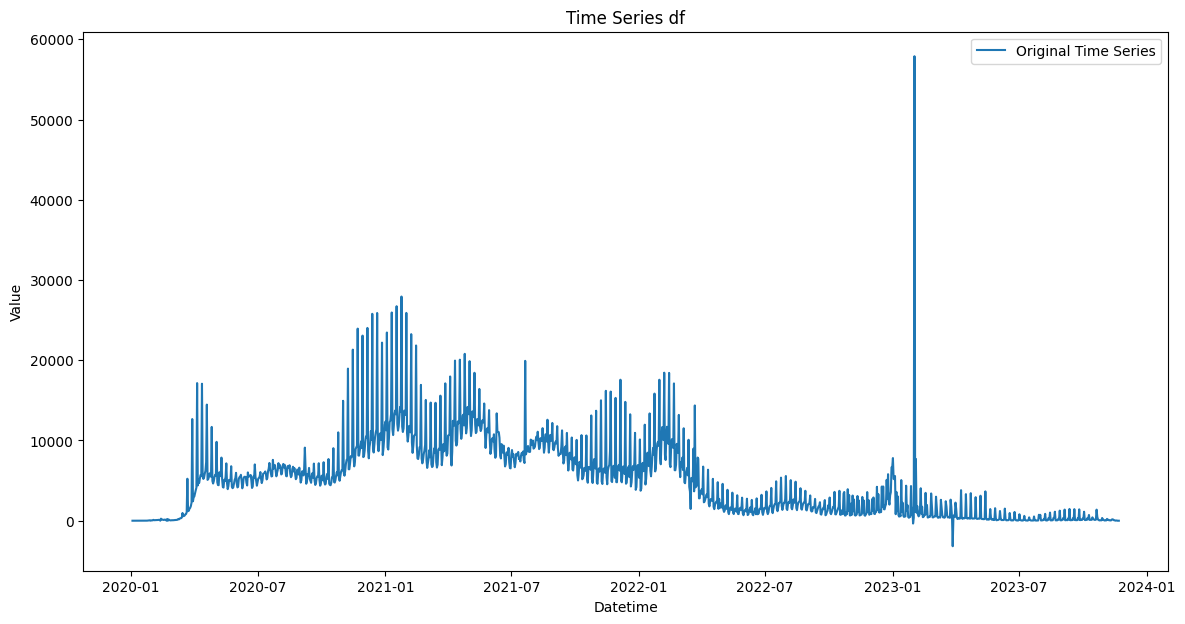

In [21]:
# Plot the entire time series df
plt.figure(figsize=(14, 7))
plt.plot(df[target_column], label="Original Time Series")
plt.title("Time Series df")
plt.xlabel("Datetime")
plt.ylabel("Value")
plt.legend()
plt.show()

Decompose the time series into trend, seasonal, and residual components

In [22]:
decomposition = seasonal_decompose(df[target_column], model="aditive", period=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

Plot the original time series, trend, seasonal, and residual components

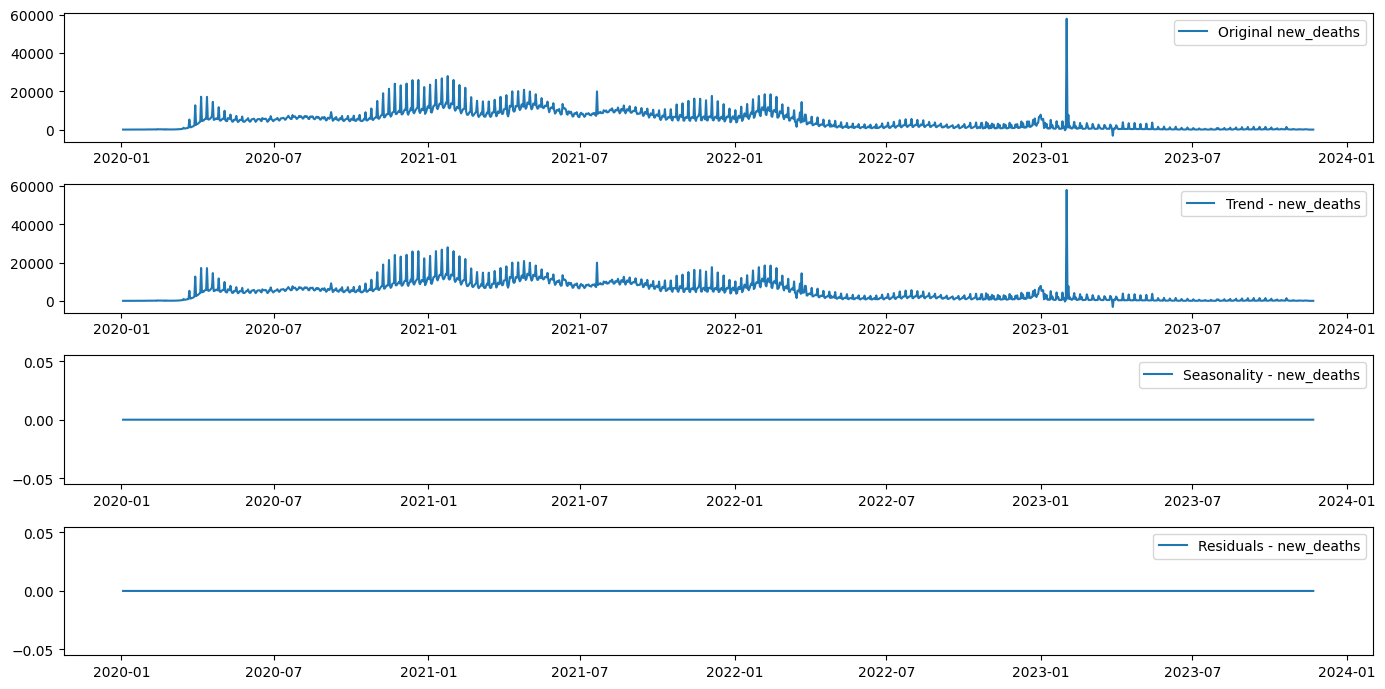

count     1420.000000
mean      4916.382394
std       4869.880900
min      -3179.000000
25%        746.000000
50%       4517.000000
75%       7720.250000
max      57889.000000
Name: New_deaths, dtype: float64


In [23]:
plt.figure(figsize=(14, 7))

plt.subplot(411)
plt.plot(df[target_column], label=f"Original new_deaths")
plt.legend(loc="best")

plt.subplot(412)
plt.plot(trend, label=f"Trend - new_deaths")
plt.legend(loc="best")

plt.subplot(413)
plt.plot(seasonal, label=f"Seasonality - new_deaths")
plt.legend(loc="best")

plt.subplot(414)
plt.plot(residual, label=f"Residuals - new_deaths")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# Display summary statistics for the current target_column
print(df[target_column].describe())

Plot ACF and PACF

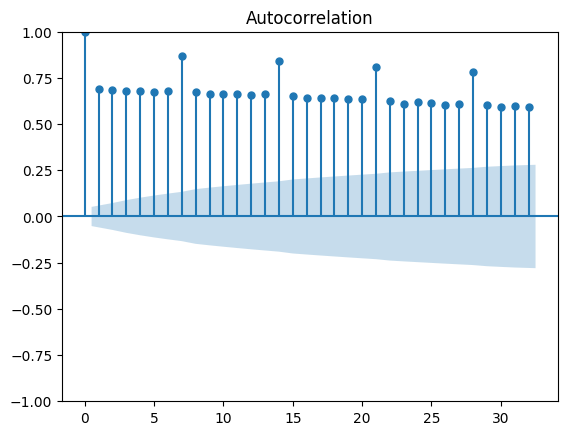

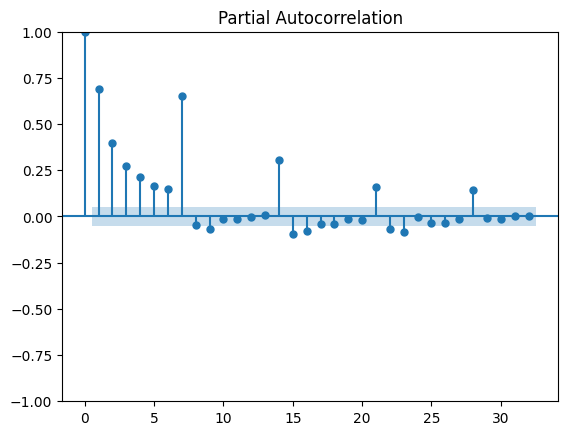

In [24]:
plot_acf(df[[target_column]])
plt.show()

plot_pacf(df[[target_column]])
plt.show()

Determine whether the dataset is stationary

In [25]:
def adf_test(dataset):
    dftest = adfuller(dataset, autolag="AIC")
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t", key, ": ", val)


adf_test(df[target_column])

1. ADF :  -1.7571154799121884
2. P-Value :  0.40195075434017785
3. Num Of Lags :  22
4. Num Of Observations Used For ADF Regression: 1397
5. Critical Values :
	 1% :  -3.4350395894411734
	 5% :  -2.863611117606763
	 10% :  -2.5678726562185354


In [26]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df)
profile.to_file("profile_report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 247.07it/s]


0


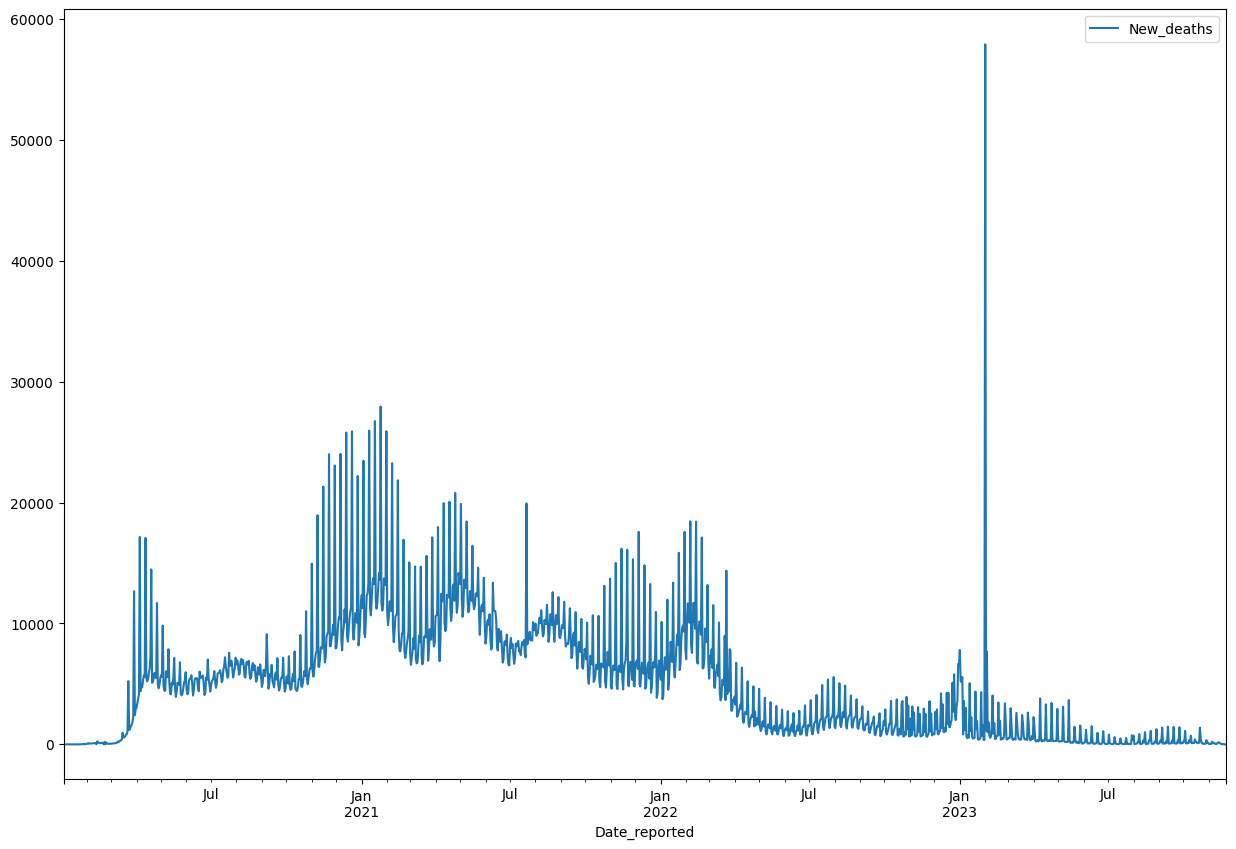

In [27]:
file_path = "./data/WHO-COVID-19-global-data.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=[date_column])
# df_max = df[target_column].max()
df = df[df[target_column] >= 0]
# df = df[df[target_column] != df_max]
# df[target_column] = df[target_column] + 1
df.to_csv('./data/parsed_dataset.csv')

date = df[date_column]
df = df.groupby(date_column).sum().reset_index()
df.set_index(date_column, inplace=True)
plot_cols = [target_column]
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True, figsize=(15, 10))
print(df[target_column].min())